Author Interactivity Time
===

Visualize the "inter-activity time" to see what kind of patterns exist.

Relevant paper: https://arxiv.org/pdf/1411.2878.pdf

In [2]:
%matplotlib inline

from pathlib import Path
import os
import subprocess

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
import scipy, scipy.stats
from scipy.stats import lognorm
# https://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stats.lognorm.html

In [4]:
# This is the key dependency for fitting the lognormal distribution to the data
import pomegranate
from pomegranate import *

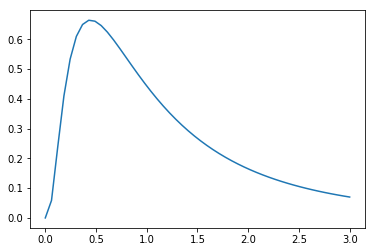

In [5]:
[ s ] = [0.9,]*lognorm.numargs
rv = lognorm(s)
x = np.linspace(0,np.minimum(rv.dist.b,3))
h=plt.plot(x,rv.pdf(x))
plt.show()

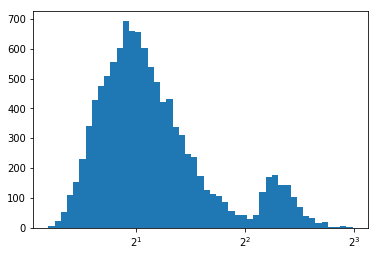

In [6]:
R = lognorm.rvs(0.5, loc=1, scale=1, size=10000)
R2 = lognorm.rvs(0.5, loc=4, scale=1, size=1000)
x = np.concatenate([R, R2])
num_bins = 50
base=2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins)
plt.xscale('log', nonposx='clip', basex=base)
plt.show()

In [7]:
# try to learn a 2-component lognormal mixture model on the data
x_train = x.reshape(-1, 1)
model = GeneralMixtureModel.from_samples([LogNormalDistribution, LogNormalDistribution], 
                                         n_components=2, X=x_train,
                                         stop_threshold=0.01)
model

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                0.7103662979923806,
                0.23116915761270432
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                1.5959795641733892,
                0.13685717149922327
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.887896978292175,
        0.11210302170782505
    ]
}

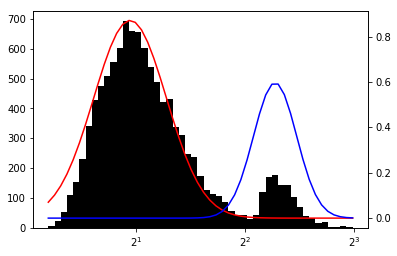

In [8]:
num_bins = 50
base=2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='black')
plt.xscale('log', nonposx='clip', basex=base)
ax2 = plt.gca().twinx()
# plot the probability density of learned lognormal distributions
ax2.plot(logbins, [np.exp(model.distributions[0].log_probability(bin_edge)) for bin_edge in logbins], color='red')
ax2.plot(logbins, [np.exp(model.distributions[1].log_probability(bin_edge)) for bin_edge in logbins], color='blue')
plt.show()

### Now trying with actual interactions data...

In [27]:
pwd = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data/"
#pwd = "/home/levon003/repos/sna-social-support/network_data"

data = pd.read_pickle(os.path.join(pwd, "interactivity.pickle"))

In [25]:
#Counter(data.uid).most_common()[:5]

In [16]:
x = []
error_count = 0
for record in data.values():
    if str(record) == "...":
        error_count += 1
    else:
        x.extend(record)
print(f"{len(x)} records found for activity differences; {error_count} of which ({error_count/len(x)}%) contain errors")

14232134 records found for activity differences; 0 of which (0.0%) contain errors


In [17]:
# To account for interactions that are recorded at the same timestamp, I treat these as having a difference as 1
# (lazily, I accomplish this by incrementing all interactivity times by 1)
x_trimmed = np.array(x) + 1
np.min(x_trimmed), np.max(x_trimmed), np.mean(x_trimmed)

(1.0, 63535761900001.0, 844885356.227122)

In [18]:
x_trimmed = np.array([val for val in x if val >= 1])
len(x_trimmed) / len(x)

0.9251895745219937

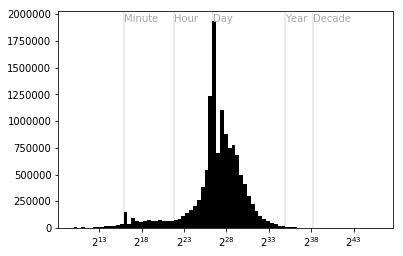

In [19]:
num_bins = 80
base=2
logbins = np.logspace(np.log2(min(x_trimmed)), np.log2(max(x_trimmed)), num=num_bins, base=base, endpoint=True)
plt.hist(x_trimmed, bins=logbins, color='black')
plt.xscale('log', nonposx='clip', basex=base)

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1000 * 60, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24 * 365, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24 * 365 * 10, color='black', alpha=0.1)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.95))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1000 * 60, text_y, 'Minute', color='darkgray')
ax.text(1000 * 60 * 60, text_y, 'Hour', color='darkgray')
ax.text(1000 * 60 * 60 * 24, text_y, 'Day', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 365, text_y, 'Year', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 365 * 10, text_y, 'Decade', color='darkgray')

plt.show()

In [20]:
x_train = x_trimmed.reshape(-1, 1)
model = GeneralMixtureModel.from_samples([LogNormalDistribution, LogNormalDistribution], 
                                         n_components=2, X=x_train,
                                         stop_threshold=0.01)
model

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                18.512790810958865,
                2.378897465143882
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                31.78163358681834,
                0.0010060760634606131
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.9999974953063192,
        2.504693680808299e-06
    ]
}

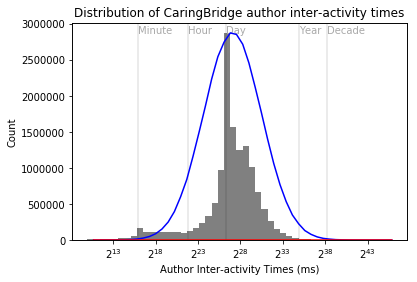

In [21]:
# not looking good! decidedly not bimodal, and the model fit is horrible as a result
# note that the model above IS learning the mean correctly: np.log2(np.e**15.89) is the correct peak
# however, the returned densities seem to be on the totally wrong scale... I'm not actually sure what I'm doing wrong here
# it's possible that this would just be fixed in a better model fit
num_bins = 50
base=2
logbins = np.logspace(np.log2(min(x_trimmed)), np.log2(max(x_trimmed)), num=num_bins, base=base, endpoint=True)
plt.hist(x_trimmed, bins=logbins, color='gray')
plt.xscale('log', nonposx='clip', basex=base)

plt.xlabel("Author Inter-activity Times (ms)")
plt.ylabel("Count")
plt.title("Distribution of CaringBridge author inter-activity times")

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1000 * 60, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24 * 365, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24 * 365 * 10, color='black', alpha=0.1)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.95))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1000 * 60, text_y, 'Minute', color='darkgray')
ax.text(1000 * 60 * 60, text_y, 'Hour', color='darkgray')
ax.text(1000 * 60 * 60 * 24, text_y, 'Day', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 365, text_y, 'Year', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 365 * 10, text_y, 'Decade', color='darkgray')

ax2 = plt.gca().twinx()

vals = model.distributions[0].sample(int(1000000 * np.exp(model.weights[0])))
hist, _ = np.histogram(vals, bins=logbins, density=False)
ax2.plot(logbins[1:], hist, color='blue')

vals = model.distributions[1].sample(int(1000000 * np.exp(model.weights[1])))
hist, _ = np.histogram(vals, bins=logbins, density=False)
ax2.plot(logbins[1:], hist, color='red')
ax2.hist([0], bins=logbins) # this is a cheaty way to force the right yaxis to align 0 along the baseline

# turn off yticks
ax2.tick_params(axis='y', right=False, labelright=False)

plt.show()

In [22]:
# 95% of author inter-activity times are less than 312 days (0.85 years)
# that number drops to 28 days when using my method for loading the x list
np.quantile(x, 0.95) / 1000 / 60 / 60 / 24 # days

25.67013888888889

In [23]:
# TODO Visualize the distributions of the minimum and maximum times per user